<a href="https://colab.research.google.com/github/annvorosh/GB/blob/Alg_AD/Alg_AD_L4_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 4. Деревья решений

1. В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.


In [939]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [940]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=200, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=42)

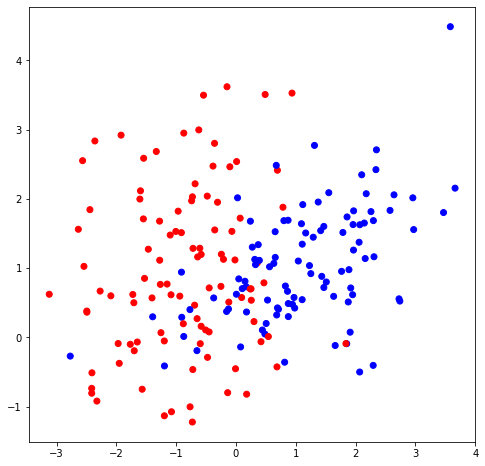

In [941]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [942]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [943]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [944]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [945]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [946]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [947]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [948]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, deep_tree = 5, count = 0):
    
    quality, t, index = find_best_split(data, labels)
   
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
# КРИТЕРИЙ ОСТАНОВА
    # в бинарном дереве нет смысла считать листья так как количество листьев будет 2**n, где n - глубина дерева
    # соответственно мы можем ограничить глубину: 
    if count >= deep_tree:
        return Leaf(data, labels)
     
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    # счетчик глубины дерева
    count += 1
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [949]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [950]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [951]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [952]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
print_tree(my_tree)

Индекс 0
Порог 0.30162791131955324
--> True:
  Индекс 0
  Порог -0.9125222105355059
  --> True:
    Индекс 0
    Порог -2.493808576360128
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог -0.7696559316782248
    --> True:
      Прогноз: 1
    --> False:
      Индекс 0
      Порог -0.0074544069644085775
      --> True:
        Индекс 1
        Порог 0.5693816732456383
        --> True:
          Индекс 1
          Порог -0.28851949218585626
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Индекс 0
        Порог 0.1767746427001431
        --> True:
          Индекс 0
          Порог 0.07025051469619181
          --> True:
            Прогноз: 1
          --> False:
            Прогноз: 1
        --> False:
          Прогноз: 0
--> False:
  Индекс 1
  Порог -0.06259904221322055
  --> True:
    Прогноз: 1
  --> False:
    Индекс 0
    Порог

In [953]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
train_answers[:5]

[1, 0, 1, 0, 0]

In [954]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [955]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [956]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

89.28571428571429

In [957]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

85.0

Text(0.5, 1.0, 'Test accuracy=85.00')

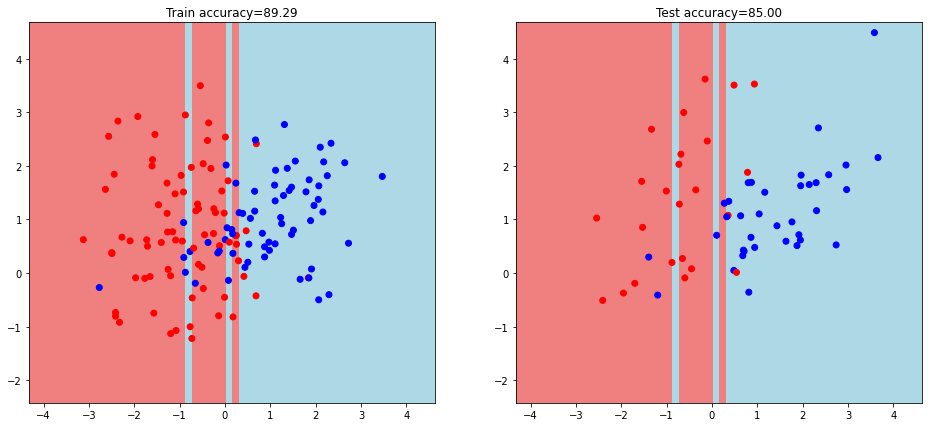

In [958]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) # список массивов координатных сеток

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [959]:
from sklearn.metrics import r2_score # R-квадрат для оценки эффективности регрессионной модели

In [960]:
# сгенерируем регресионные данные
X, y = datasets.make_regression(n_samples=200, n_features=5, n_informative=2, random_state=42)

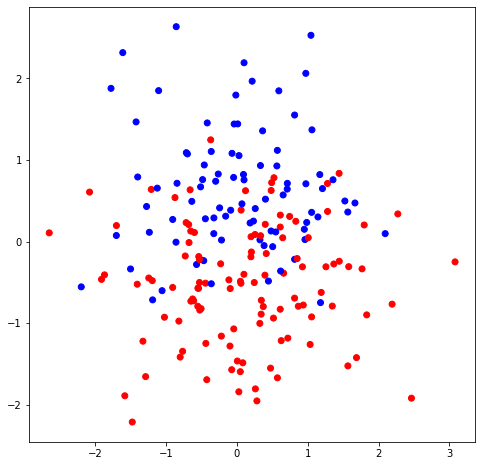

In [961]:
# визуализируем сгенерированные данные

# colors = ListedColormap(['red', 'blue'])
# light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), 
              c=y, cmap=colors)

In [962]:
X.shape

(200, 5)

In [963]:
# Разобьем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 15)

In [964]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# Реализуем класс листа для задачи регрессии

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)        
        return prediction          

In [965]:
# Расчет критерия

def dis(labels):

    for label in labels:
        dis = np.mean((labels - np.mean(labels))**2) 
    return dis

# Расчет качества

def quality(left_labels, right_labels, current_quality):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_quality - p * dis(left_labels) - (1 - p) * dis(right_labels)

In [966]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    current_criterion = dis(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [967]:
# Построим дерево по обучающей выборке
my_tree = build_tree(X_train, y_train, deep_tree = 5)
print_tree(my_tree)

Индекс 1
Порог -0.012246772846914623
--> True:
  Индекс 2
  Порог 0.29612027706457605
  --> True:
    Индекс 1
    Порог -1.0700847663261526
    --> True:
      Прогноз: -32.16886576656205
    --> False:
      Индекс 2
      Порог -1.1105758454658288
      --> True:
        Прогноз: -28.000878876126013
      --> False:
        Индекс 2
        Порог -0.01851313599238993
        --> True:
          Индекс 1
          Порог -0.5020542243526112
          --> True:
            Индекс 2
            Порог -0.5601810401969696
            --> True:
              Прогноз: -19.390329169242005
            --> False:
              Прогноз: -15.226345846505803
          --> False:
            Прогноз: -11.332166834859574
        --> False:
          Прогноз: -5.531109599910789
  --> False:
    Индекс 1
    Порог -0.7904744554453119
    --> True:
      Прогноз: -11.31405812565931
    --> False:
      Индекс 2
      Порог 1.551151975522523
      --> True:
        Индекс 2
        Порог 0.915402117702

In [968]:
    # ответы для обучающей выборки 
train_answers = predict(X_train, my_tree)
    # ответы для тестовой выборки
answers = predict(X_test, my_tree)

    # Точность на обучающей выборке
train_accuracy = r2_score(y_train, train_answers)
print(f'Train accuracy = {train_accuracy}')
    # Точность на тестовой выборке
test_accuracy = r2_score(y_test, answers)
print(f'Test accuracy = {test_accuracy}')

Train accuracy = 0.9595580715486921
Test accuracy = 0.9065647282064928
